In [11]:
%reload_ext autoreload
%autoreload 2

In [12]:
from fastai import *
from fastai.vision import *
import torch
from torch import nn
from dsin.ae.data_manager.data_loader import (
    SideinformationImageImageList, ImageSiTuple)
from dsin.ae import config
from dsin.ae.si_ae import SideInformationAutoEncoder
from dsin.ae.si_net import SiNetChannelIn
from dsin.ae.loss_man import LossManager
from dsin.ae.distortions import Distortions, DistTypes
from dsin.ae.kitti_normalizer import ChangeImageStatsToKitti, ChangeState
from dsin.ae import config


In [13]:
config.H_target = 2* 0.3
# config.autoencoder_loss_distortion_to_minimize=DistTypes.MS_SSMIM
config.K_MS_SSIM=500
config.beta

500

In [14]:
import time
import datetime
import logging

logger = logging.getLogger()

def setup_file_logger(log_file='out.log'):
    hdlr = logging.FileHandler(log_file)
    formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
    hdlr.setFormatter(formatter)
    logger.addHandler(hdlr) 
    logger.setLevel(logging.INFO)
    logger.info("start")

setup_file_logger()

In [15]:
class AverageMetric(Callback):
    "Wrap a `func` in a callback for metrics computation."
    def __init__(self, func,name):
        # If it's a partial, use func.func
        #         name = getattr(func,'func',func).__name__
        self.func, self.name = func, name

    def on_epoch_begin(self, **kwargs):
        "Set the inner value to 0."
        self.val, self.count = 0.,0

    def on_batch_end(self, last_output, last_target, **kwargs):
        "Update metric computation with `last_output` and `last_target`."
        if not is_listy(last_target): last_target=[last_target]
        self.count += last_target[0].size(0) # batch size
        
        if last_output[0] is None:
            X_OUTPUT = 1 # X_DEC
        else:
            X_OUTPUT = 0 # X_HAT_OUT
        val = self.func(last_output[X_OUTPUT], last_target[0])
        self.val += last_target[0].size(0) * val.detach().cpu()
        
    
    
    def on_epoch_end(self, last_metrics, **kwargs):
        "Set the final result in `last_metrics`."
        return add_metrics(last_metrics, self.val/self.count)
    
class ParameterMetricCallback(Callback):
    def __init__(self,loss_man):
        self.loss_man = loss_man
    
    def on_backward_begin(self,*args, **kwargs):
        self.pbar=kwargs["pbar"]
        if hasattr(self.loss_man,'soft_bit_entropy'):
            self.pbar.child.comment += f' soft_bit_entropy: {self.loss_man.soft_bit_entropy:.4f}'

class ParameterRunningAverageMetricCallback(Callback):
    def __init__(self,loss_man,alpha=0.1):
        self.loss_man = loss_man
        self.alpha = alpha
        self.val = None
    
    def on_backward_begin(self,*args, **kwargs):
        self.pbar=kwargs["pbar"]
        self.importance_map=kwargs["last_output"][3].detach()
#         import pdb
#         pdb.set_trace()
        if hasattr(self.loss_man,'soft_bit_entropy'):
            if self.val is None:
                self.val = self.loss_man.soft_bit_entropy.detach()
            else:
                self.val *= 1 - self.alpha
                self.val += self.alpha * self.loss_man.soft_bit_entropy.detach()
                
            self.pbar.child.comment += f' avg_bpp: {self.val / 2 :.4f} imp-mean-var {(torch.mean(self.importance_map),torch.var(self.importance_map))}'
    

In [16]:
class BitEntropy(Callback):
    "Wrap a `func` in a callback for metrics computation."
    def __init__(self,loss_man,alpha=0.1, logger=logger):
        # If it's a partial, use func.func
        #         name = getattr(func,'func',func).__name__
        self.loss_man = loss_man
        self.alpha = alpha
        self.logger = logger
        
    def on_epoch_begin(self, **kwargs):
        "Set the inner value to 0."
        self.val = 0.0
        self.iter = 0
        
    def on_batch_end(self, last_output, last_target, **kwargs):
        "Update metric computation with `last_output` and `last_target`."
      
        self.val *= 1 - self.alpha
        self.val += self.alpha * self.loss_man.soft_bit_entropy.detach()

        if self.iter % 500 == 0 :
            importance_map  = last_output[3].detach()
            msg = f"iter {self.iter}: bpp = {self.val / 2:.3f}, impmap- mean {torch.mean(importance_map):.4f} var {torch.var(importance_map):.4f} "
            msg += f" total loss{self.loss_man.total_loss:.1f}"
            self.logger.info(msg)
            print(msg)
        self.iter += 1

    def on_epoch_end(self, last_metrics, **kwargs):
        "Set the final result in `last_metrics`."
        return add_metrics(last_metrics, self.val)
    

In [17]:
config.use_si_flag = SiNetChannelIn.WithSideInformation
config.use_si_flag

<SiNetChannelIn.WithSideInformation: 6>

In [18]:
torch.__version__

'1.5.1'

In [19]:
si_autoencoder = SideInformationAutoEncoder(config.use_si_flag)
path = "../src/dsin/data"
pct= 1 #0.0005 #0.25

valid_image_list = SideinformationImageImageList.from_csv(
    path=path, csv_names=["KITTI_baseline_val.txt"],pct=pct)
train_image_list = SideinformationImageImageList.from_csv(
    path=path, csv_names=["KITTI_baseline_train.txt"],pct=pct)

image_lists = ItemLists(
    path=path, train=train_image_list, valid=valid_image_list)

# ll = image_lists.label_from_func(lambda x: x)

tfms =  get_transforms(do_flip=True, flip_vert=False, max_rotate=None, max_zoom=1., max_lighting=None, max_warp=None, p_affine=0.0, p_lighting=0.0)
 #get_transforms(do_flip=True, max_rotate=0.0) # None #
batchsize = 1
# [flip_lr(p=0.5),[]]
data = (image_lists
        .label_from_func(lambda x: x)
        .transform(None, size=(336, 1224), resize_method=ResizeMethod.CROP, tfm_y=True)
        .databunch(bs=batchsize))
learn = Learner(data=data,
                     model=si_autoencoder,
                     opt_func=torch.optim.Adam,
                     loss_func=LossManager(config.use_si_flag),
                     metrics=[AverageMetric(Distortions._calc_dist,"MS_SSIM")])

# learn.metrics.append(BitEntropy(loss_man=learn.loss_func))

In [ ]:
model_fname = '200807MAE-l2reg-baseline'
for i in range(2,5):
    if i != 1 :
        learn.load(f'{model_fname}-{i - 1}',with_opt=True)
    
    config.si_loss_weight_alpha = 0
    learn.model.true_tuple_loss_false_just_out = True
    learn.model.use_side_infomation = SiNetChannelIn.NoSideInformation
    learn.loss_func.use_side_infomation = SiNetChannelIn.NoSideInformation
    learn.fit(1, lr=0.0001,wd=0,callbacks=[ParameterRunningAverageMetricCallback(learn.loss_func),BitEntropy(loss_man=learn.loss_func)])
    learn.save(f'{model_fname}-{i}')
    !aws s3 cp ~/tDSIN/src/dsin/data/models/{model_fname}-{i}.pth  s3://dsin-us/models/
    !aws s3 cp ~/tDSIN/tutorials/out.log s3://dsin-us/models/


epoch,train_loss,valid_loss,MS_SSIM,time


iter 0: bpp = 0.052, impmap- mean 0.3989 var 0.2398  total loss283.5
iter 500: bpp = 0.483, impmap- mean 0.3564 var 0.2294  total loss249.6
iter 1000: bpp = 0.471, impmap- mean 0.3174 var 0.2166  total loss206.0
iter 1500: bpp = 0.435, impmap- mean 0.2881 var 0.2051  total loss208.0
iter 2000: bpp = 0.388, impmap- mean 0.2138 var 0.1680  total loss131.5
iter 2500: bpp = 0.396, impmap- mean 0.2250 var 0.1744  total loss146.1
iter 3000: bpp = 0.392, impmap- mean 0.2162 var 0.1694  total loss140.5
iter 3500: bpp = 0.401, impmap- mean 0.2331 var 0.1787  total loss150.9
iter 4000: bpp = 0.384, impmap- mean 0.1960 var 0.1576  total loss109.0
iter 4500: bpp = 0.411, impmap- mean 0.2287 var 0.1764  total loss152.3
iter 5000: bpp = 0.412, impmap- mean 0.2430 var 0.1839  total loss166.4


In [12]:
learn.save(f'MAE-l2reg-baseline-3')

In [13]:
    !aws s3 cp ~/tDSIN/src/dsin/data/models/MAE-l2reg-baseline-3.pth  s3://dsin-us/models/


upload: ../src/dsin/data/models/MAE-l2reg-baseline-3.pth to s3://dsin-us/models/MAE-l2reg-baseline-3.pth


In [11]:

learn.load('MAE-l2reg-baseline-1')
config.si_loss_weight_alpha = 0
learn.model.true_tuple_loss_false_just_out = True
learn.model.use_side_infomation = SiNetChannelIn.NoSideInformation
learn.loss_func.use_side_infomation = SiNetChannelIn.NoSideInformation
learn.fit(1, lr=0.0001,wd=0,callbacks=[ParameterRunningAverageMetricCallback(learn.loss_func)])


epoch,train_loss,valid_loss,MS_SSIM,time
0,528.013000,449.383850,277.891815,00:04


In [14]:
learn.save('MAE-l2reg-baseline-2')

In [ ]:
learn.load('MSSIM-1000-l2reg-baseline-1')
learn.model.true_tuple_loss_false_just_out = True
learn.model.use_side_infomation = SiNetChannelIn.NoSideInformation
learn.loss_func.use_side_infomation = SiNetChannelIn.NoSideInformation
learn.fit(1, lr=0.0001,wd=0,callbacks=[ParameterRunningAverageMetricCallback(learn.loss_func)])
learn.load('MSSIM-1000-l2reg-baseline-2')

In [ ]:
learn.save('l2reg-baseline-2')

In [ ]:
learn.load('l2reg-baseline-2')
learn.model.true_tuple_loss_false_just_out = True
learn.model.use_side_infomation = SiNetChannelIn.NoSideInformation
learn.loss_func.use_side_infomation = SiNetChannelIn.NoSideInformation
learn.fit(1, lr=0.0001,wd=0,callbacks=[ParameterMetricCallback(learn.loss_func),ParameterRunningAverageMetricCallback(learn.loss_func)])
learn.load('l2reg-baseline-3')


In [ ]:
learn.model.my_tuple[5]


In [ ]:
learn.data.train_ds[1][0].img

In [ ]:
learn.data.train_ds[1][0].si_img

In [ ]:
learn.loss_func.soft_bit_entropy

In [ ]:
config.si_loss_weight_alpha

In [ ]:
learn.loss_func.autoencoder_loss_value

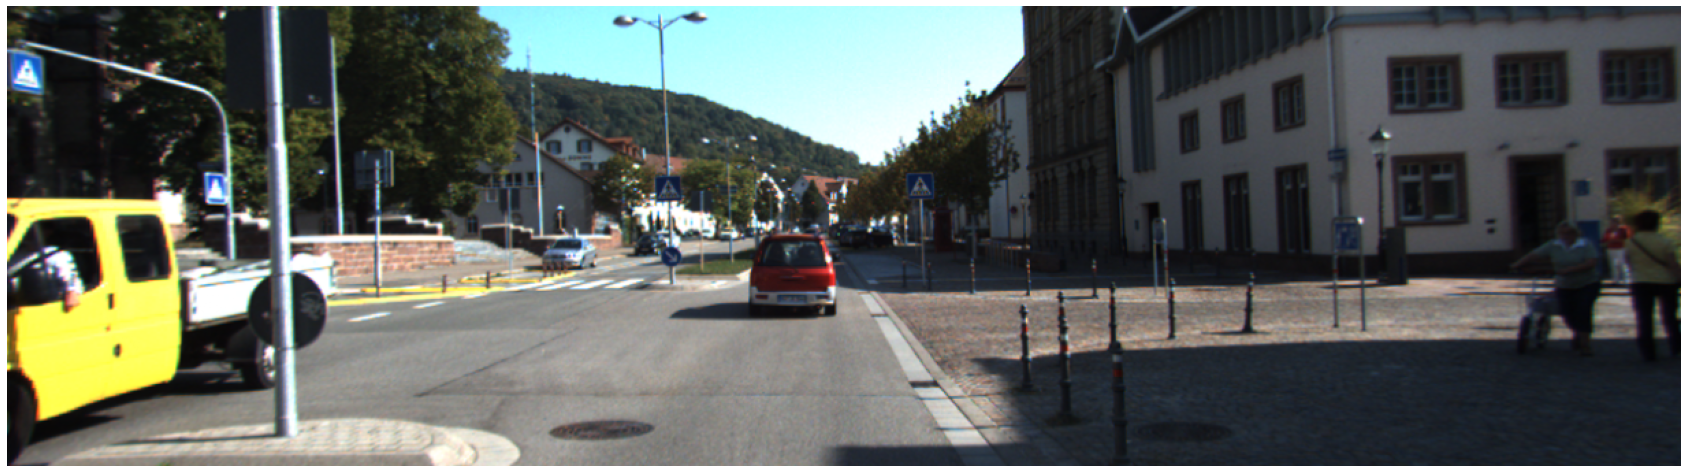

In [16]:
mt = learn.model.my_tuple[-2].squeeze_().detach()
mx, mn =torch.max(mt), torch.min(mt)
diff = mx-mn
show_image(Image((mt - mn)/(diff)),figsize=(30,30))
# # print(mn)

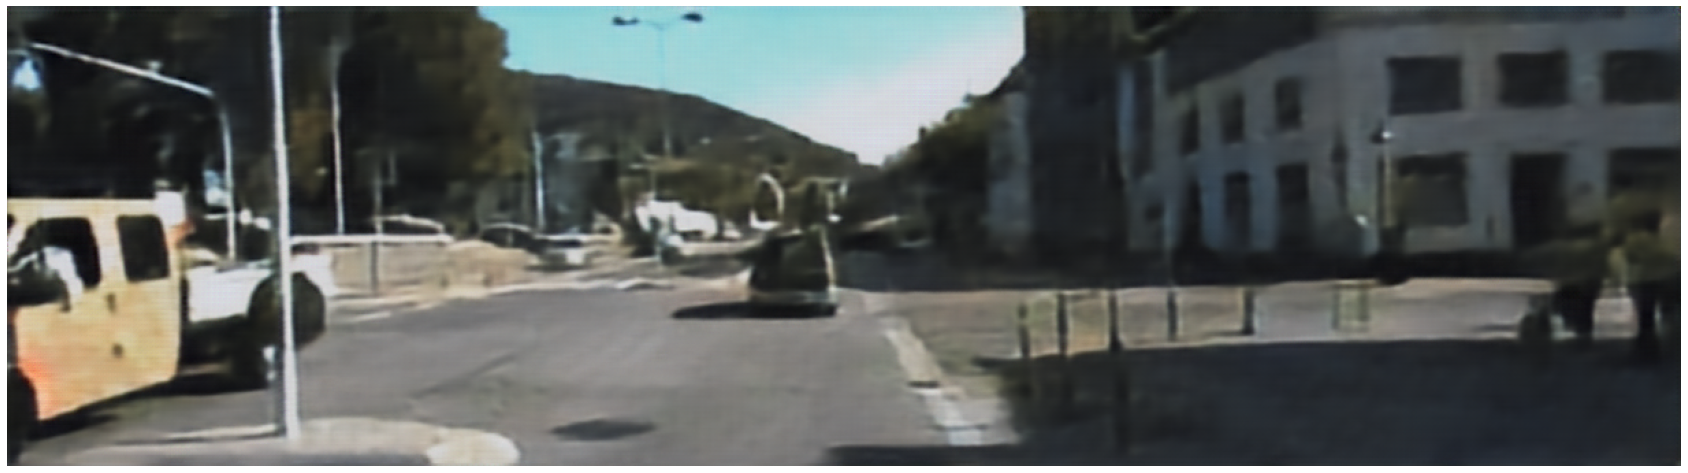

In [10]:

# # show_image(Image(learn.model.my_tuple[0][:,:50,:50]/255))
# # Image(learn.model.my_tuple[2].squeeze_().detach()/255.0)
mt = learn.model.my_tuple[3].squeeze_().detach()
mx, mn =torch.max(mt), torch.min(mt)
diff = mx-mn
show_image(Image((mt - mn)/(diff)),figsize=(30,30))
# # print(mn)

# torch.min(learn.model.my_tuple[2].squeeze_().detach())

In [ ]:
aaa = (mt - mn)/(diff)

flip_lr(Image(aaa.cpu()))

In [ ]:
# learn.model.true_tuple_loss_false_just_out = False

# learn.show_results(figsize=(30,30))

In [ ]:
learn.model.my_tuple[-2].data